IMPORTING LIBRARIES

In [ ]:
#!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable


In [22]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import plotly.express as px
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import re
import joblib

loading the dataset

In [24]:
# Download latest version
path = "naserabdullahalam/phishing-email-dataset"

print("Path to dataset files:", path)


Path to dataset files: naserabdullahalam/phishing-email-dataset


In [25]:
import os

print("Files in dataset directory:")
print(os.listdir(path))

Files in dataset directory:


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'naserabdullahalam/phishing-email-dataset'

In [27]:
df = pd.read_csv("C:\\Users\\vutom\\Downloads\\COS720_Project-20250503T142431Z-1-001\\COS720_Project\\phishing_email.csv")
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [28]:
df.tail()

,text_combined,label
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1
82485,fastway infofastwaycoza_infofastwaycoza_infofa...,1


#  *PREPROCCESSING*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


the data is already labelled no need for label encoders , lets check for missing values before we feature engineer the data

In [29]:
df.isnull().sum()

text_combined    0
label            0
dtype: int64

In [30]:
df.duplicated().any()

np.True_

In [32]:
# Dropping the dupicates
df = df.drop_duplicates()


In [33]:
df.shape

(82078, 2)

Feature engineering the  dataset

In [ ]:
def extract_features(text):
    try:
    # Subject: Look for date-like or title-like text at the start
    subject_pattern = r'^.*?(\d{1,2}\s*(?:th|st|nd|rd)?\s*(?:january|february|march|april|may|june|july|august|september|october|november|december)?\s*\d{4})'
    sender_pattern = r'(forwarded\s+by\s+)?(\w+\s+\w+)'  # Rough sender guess
    content_start = r'(see attached file|forwarded|estimated)'

    # Extract subject
    subject_match = re.search(subject_pattern, text, re.IGNORECASE)
    if subject_match:
        subject = text[:subject_match.end()].strip()
        remaining_text = text[subject_match.end():].strip()
    else:
        subject = 'No Subject'
        remaining_text = text

    # Extract sender (if present)
    sender_match = re.search(sender_pattern, remaining_text, re.IGNORECASE)
    sender = sender_match.group(2) if sender_match else 'Unknown Sender'

    # Extract content (after subject or sender clues)
    content_match = re.search(content_start, remaining_text, re.IGNORECASE)
    content = remaining_text[content_match.start():].strip() if content_match else remaining_text

    return pd.Series({'subject': subject, 'sender': sender, 'content': content})
    except:
        return pd.Series({'subject': np.nan, 'sender': np.nan, 'content': np.nan})


df[['subject', 'sender', 'content']] = df['text_combined'].apply(extract_features)


print(df[['subject', 'sender', 'content', 'label']])

                                                 subject  \
0                                    hpl nom may 25 2001   
1      nom actual vols 24 th forwarded sabrae zajac h...   
2      enron actuals march 30 april 1 201 estimated a...   
3                                    hpl nom may 30 2001   
4                                    hpl nom june 1 2001   
...                                                  ...   
82481  info advantageapartmentscom infoadvantageapart...   
82482  monkeyorg helpdeskmonkeyorg monkeyorg hi josep...   
82483  help center infohelpcentercoza_infohelpcenterc...   
82484  metamask infosofamekarcom verify metamask wall...   
82485  fastway infofastwaycoza_infofastwaycoza_infofa...   

                           sender  \
0                    see attached   
1                           12 07   
2                      flow march   
3                    see attached   
4                    see attached   
...                           ...   
82481               

# ***VISUALIZATION***

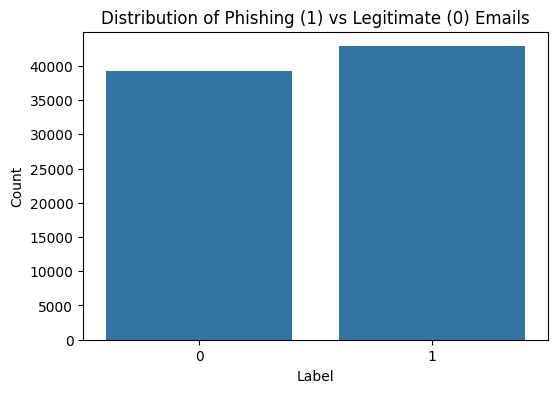

In [35]:
# Add length features for visualization
df['subject_length'] = df['subject'].str.len()
df['content_length'] = df['content'].str.len()

# 1. Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Phishing (1) vs Legitimate (0) Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('label_distribution.png')
plt.show()

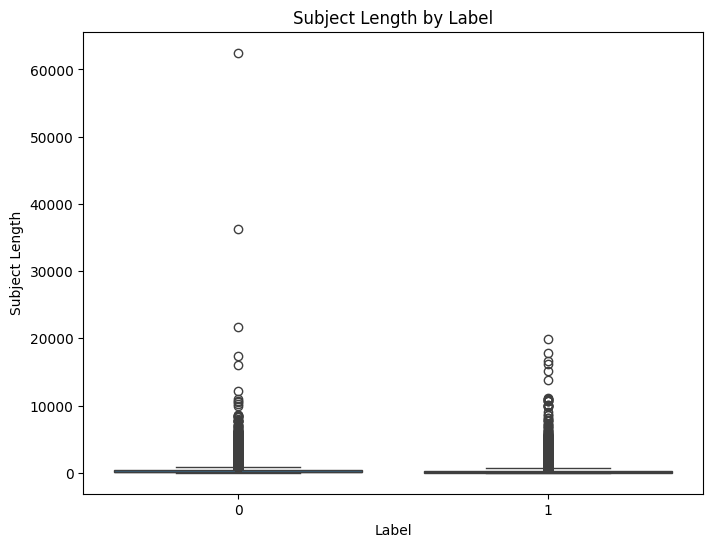

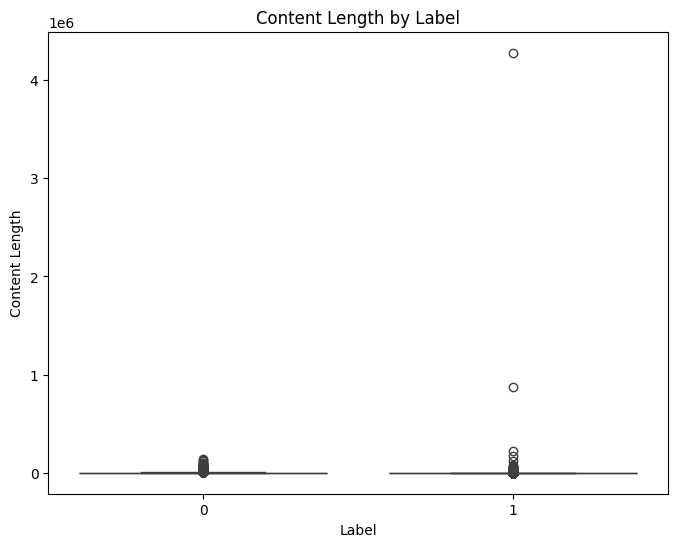

In [36]:
# 2. Text Lengths by Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='subject_length', data=df)
plt.title('Subject Length by Label')
plt.xlabel('Label')
plt.ylabel('Subject Length')
plt.savefig('subject_length.png')
plt.show

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='content_length', data=df)
plt.title('Content Length by Label')
plt.xlabel('Label')
plt.ylabel('Content Length')
plt.savefig('content_length.png')
plt.show()

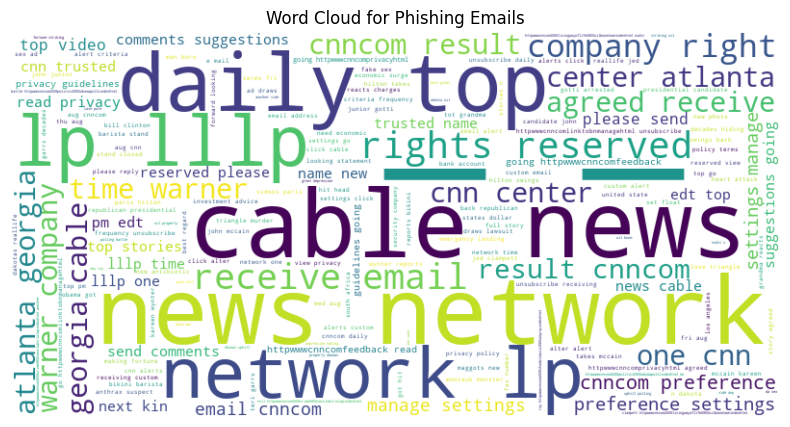

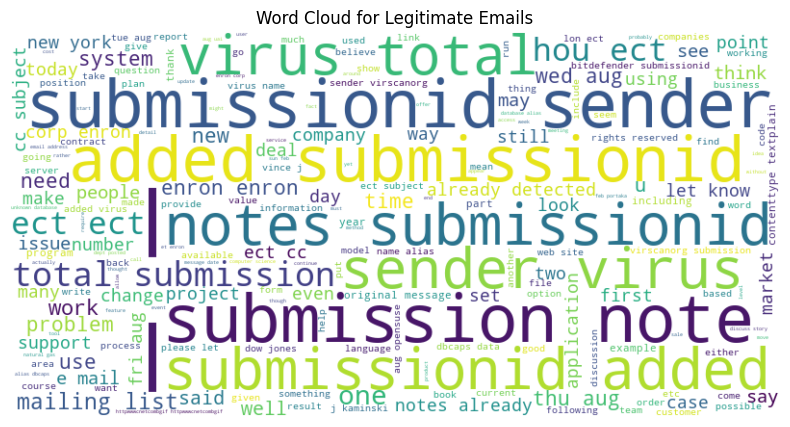

EDA visualizations saved: label_distribution.png, subject_length.png, content_length.png, phishing_wordcloud.png, legit_wordcloud.png


In [37]:
# 3. Word Clouds
phishing_text = ' '.join(df[df['label'] == 1]['content'].fillna(''))
legit_text = ' '.join(df[df['label'] == 0]['content'].fillna(''))

if phishing_text:
    phishing_wc = WordCloud(width=800, height=400, background_color='white').generate(phishing_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(phishing_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Phishing Emails')
    plt.savefig('phishing_wordcloud.png')
    plt.show()

if legit_text:
    legit_wc = WordCloud(width=800, height=400, background_color='white').generate(legit_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(legit_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Legitimate Emails')
    plt.savefig('legit_wordcloud.png')
    plt.show()

print("EDA visualizations saved: label_distribution.png, subject_length.png, content_length.png, phishing_wordcloud.png, legit_wordcloud.png")

# ***MODEL BUILDING***

lets train test split the data ,  since the data is fairly balanced no need for sampling techniques.

In [38]:
X = df['text_combined'].fillna('')  # Features
y = df['label']  # Labels (0 or 1)

In [39]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We will begin by comapring different models how they perform in predicting .

In [40]:
# Vectorize text with TF-IDF (tweaked for better features)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))  # Added bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [41]:
# 1. Logistic Regression (with tuned C)
lr_model = LogisticRegression(C=1.0, random_state=42, max_iter=1000)  # C=1.0 for balanced data
lr_model.fit(X_train_tfidf, y_train)
lr_y_pred = lr_model.predict(X_test_tfidf)

In [42]:
# 2. Random Forest (with tuned parameters)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)  # Limited depth to avoid overfitting
rf_model.fit(X_train_tfidf, y_train)
rf_y_pred = rf_model.predict(X_test_tfidf)

In [43]:
# 3. Neural Network (MLP with tuned architecture)
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, learning_rate_init=0.001)
nn_model.fit(X_train_tfidf, y_train)
nn_y_pred = nn_model.predict(X_test_tfidf)

In [44]:
# 4. Support Vector Machine (LinearSVC)
svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)  # Linear kernel for speed
svm_model.fit(X_train_tfidf, y_train)
svm_y_pred = svm_model.predict(X_test_tfidf)

# ***MODEL EVALUATION***

In [46]:
# Function to evaluate and print metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return model

In [47]:
#Evalauting all models
lr_model = evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression")
rf_model = evaluate_model(rf_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest")
nn_model = evaluate_model(nn_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Neural Network")
svm_model = evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Support Vector Machine")


Logistic Regression Results:
Accuracy: 0.9826
Precision: 0.9805
Recall: 0.9862
F1-Score: 0.9834

Random Forest Results:
Accuracy: 0.9504
Precision: 0.9241
Recall: 0.9860
F1-Score: 0.9540

Neural Network Results:
Accuracy: 0.9857
Precision: 0.9849
Recall: 0.9879
F1-Score: 0.9864

Support Vector Machine Results:
Accuracy: 0.9882
Precision: 0.9867
Recall: 0.9907
F1-Score: 0.9887


SVM take the cup !

In [48]:
n_samples = 50  # Number of samples to plot
indices = np.arange(n_samples)
y_test_subset = y_test[:n_samples].reset_index(drop=True)  # Reset index for plotting

# Logistic Regression Scatter Plot
lr_y_pred_subset = lr_y_pred[:n_samples]
plot_df_lr = pd.DataFrame({
    'Index': np.concatenate([indices, indices]),  # Duplicate indices for actual and predicted
    'Label': np.concatenate([y_test_subset, lr_y_pred_subset]),
    'Type': ['Actual'] * n_samples + ['Predicted'] * n_samples,
    'Offset': [0] * n_samples + [0.1] * n_samples  # Slight offset for predicted points
})
fig_lr = px.scatter(plot_df_lr, x='Index', y='Label', color='Type', symbol='Type',
                    title='Actual vs Predicted: Logistic Regression',
                    labels={'Label': 'Label (0 = Legit, 1 = Phishing)', 'Index': 'Sample Index'},
                    color_discrete_map={'Actual': '#00CC96', 'Predicted': '#EF553B'})
fig_lr.update_traces(marker=dict(size=8))
fig_lr.update_yaxes(tickvals=[0, 1], ticktext=['Legit (0)', 'Phishing (1)'])
fig_lr.show()

# Random Forest Scatter Plot
rf_y_pred_subset = rf_y_pred[:n_samples]
plot_df_rf = pd.DataFrame({
    'Index': np.concatenate([indices, indices]),
    'Label': np.concatenate([y_test_subset, rf_y_pred_subset]),
    'Type': ['Actual'] * n_samples + ['Predicted'] * n_samples,
    'Offset': [0] * n_samples + [0.1] * n_samples
})
fig_rf = px.scatter(plot_df_rf, x='Index', y='Label', color='Type', symbol='Type',
                    title='Actual vs Predicted: Random Forest',
                    labels={'Label': 'Label (0 = Legit, 1 = Phishing)', 'Index': 'Sample Index'},
                    color_discrete_map={'Actual': '#00CC96', 'Predicted': '#EF553B'})
fig_rf.update_traces(marker=dict(size=8))
fig_rf.update_yaxes(tickvals=[0, 1], ticktext=['Legit (0)', 'Phishing (1)'])
fig_rf.show()

# Neural Network Scatter Plot
nn_y_pred_subset = nn_y_pred[:n_samples]
plot_df_nn = pd.DataFrame({
    'Index': np.concatenate([indices, indices]),
    'Label': np.concatenate([y_test_subset, nn_y_pred_subset]),
    'Type': ['Actual'] * n_samples + ['Predicted'] * n_samples,
    'Offset': [0] * n_samples + [0.1] * n_samples
})
fig_nn = px.scatter(plot_df_nn, x='Index', y='Label', color='Type', symbol='Type',
                    title='Actual vs Predicted: Neural Network',
                    labels={'Label': 'Label (0 = Legit, 1 = Phishing)', 'Index': 'Sample Index'},
                    color_discrete_map={'Actual': '#00CC96', 'Predicted': '#EF553B'})
fig_nn.update_traces(marker=dict(size=8))
fig_nn.update_yaxes(tickvals=[0, 1], ticktext=['Legit (0)', 'Phishing (1)'])
fig_nn.show()

# SVM Scatter Plot
svm_y_pred_subset = svm_y_pred[:n_samples]
plot_df_svm = pd.DataFrame({
    'Index': np.concatenate([indices, indices]),
    'Label': np.concatenate([y_test_subset, svm_y_pred_subset]),
    'Type': ['Actual'] * n_samples + ['Predicted'] * n_samples,
    'Offset': [0] * n_samples + [0.1] * n_samples
})
fig_svm = px.scatter(plot_df_svm, x='Index', y='Label', color='Type', symbol='Type',
                     title='Actual vs Predicted: Support Vector Machine',
                     labels={'Label': 'Label (0 = Legit, 1 = Phishing)', 'Index': 'Sample Index'},
                     color_discrete_map={'Actual': '#00CC96', 'Predicted': '#EF553B'})
fig_svm.update_traces(marker=dict(size=8))
fig_svm.update_yaxes(tickvals=[0, 1], ticktext=['Legit (0)', 'Phishing (1)'])
fig_svm.show()

In [49]:
# Saving the model and vectorizer
joblib.dump(svm_model, 'svm_phishing_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']